In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

**_Use the button above to toggle display of raw code in this notebook_**

# Web Scraping ( www.trulia.com ): Analysis and Visualization
##### by Sabbir Mohammed

the New York Business Journal reports a drop of 186,000 residents between 2015 and 2016 in New York City. Is housing the issue?

# Initializing Packages and Loading csv(s):

Initializing Packages:

In [2]:
import comma       as com
import pandas      as pd
import numpy       as np
import seaborn     as sns
import scipy.stats as scp
from   datetime    import datetime as dt
from   matplotlib  import pyplot   as plt
from   matplotlib  import patches  as pat

plt.style.use('seaborn-whitegrid')

Loading Dataset:

In [3]:
trulia = pd.read_csv('./data/trulia_complete.csv')

In [4]:
trulia = trulia.drop('Unnamed: 0', 1)

In [5]:
trulia = trulia.astype({'zipCode':str})

In [6]:
# Adding an additional feature, 'price/sqft'
pricepersqft = pd.Series(trulia.soldPrice / trulia.sqft)
trulia['PricePerSQFT'] = pricepersqft

Checking Dataset:

In [7]:
trulia.head(10)

,address,city,soldDate,soldPrice,sqft,zipCode,borough,PricePerSQFT
0,245 E 93rd St #26C,New York,21-Dec-18,1399999.0,1056,10128,Manhattan,1325.756629
1,15 Broad St #2320,New York,21-Dec-18,2150000.0,1772,10005,Manhattan,1213.318284
2,510 W 110th St #12D,New York,21-Dec-18,660000.0,616,10025,Manhattan,1071.428571
3,405 W 50th St,New York,21-Dec-18,NaN,9775,10019,Manhattan,NaN
4,407 W 50th St,New York,21-Dec-18,NaN,9775,10019,Manhattan,NaN
5,155 W 70th St #12E,New York,21-Dec-18,950000.0,1302,10023,Manhattan,729.646697
6,200 E 66th St #E2006,New York,21-Dec-18,NaN,955,10065,Manhattan,NaN
7,200 E 24th St #1809,New York,21-Dec-18,650000.0,158337,10010,Manhattan,4.105168
8,181 E 90th St #26A,New York,21-Dec-18,3200000.0,1948,10128,Manhattan,1642.710472
9,58 W 129th St #2C,New York,21-Dec-18,494000.0,479,10027,Manhattan,1031.315240


Dataset (Rows, Columns):

In [8]:
trulia.shape

(13267, 8)

Summary of Qantitative Variables:

In [9]:
round(trulia.describe(), 2)

,soldPrice,sqft,PricePerSQFT
count,11315.00,13267.00,11315.00
mean,880200.73,6032.99,573.92
std,858014.41,33631.69,765.58
min,10.00,187.00,0.00
25%,520000.00,1155.00,325.42
50%,705000.00,1592.00,451.13
75%,970000.00,2292.00,661.39
max,44580000.00,883265.00,68796.30


# Handling missing values:

In [10]:
print('Number of missing values per variable:', '\n')
print(np.sum(trulia.isnull()))

Number of missing values per variable: 

address            0
city               0
soldDate           0
soldPrice       1952
sqft               0
zipCode            0
borough            0
PricePerSQFT    1952
dtype: int64


Missing Sale Prices are listings that were shown in Trulia website's 'Sold' section, but did not have a Sale Price or showed that the properties were re-listed on the market. Further investigation showed that these cases were most likely listings whose sale was not ultimately completed, or they were removed from the site entirely. 

Since their final sale price or status cannot be determined, for our purposes, they can be removed. These missing values are random (we are not dismissing any potential patterns).

In [11]:
trulia2 = trulia.loc[trulia.soldPrice.isnull() == False].reset_index(drop=True)

# Handling Outliers and Extreme Values:

**STDEVs**

Checking which listings fall outside of user-determined standard deviation. The Standard Deviation value and variable can be set in the following cell and then run to observe results:

In [12]:
stdev   = 15
feature = 'soldPrice'

avg = np.mean(trulia2[feature])
std = np.std(trulia2[feature])

sold = trulia2.loc[trulia2[feature].apply(lambda x: (np.abs(x - avg)/std))>stdev]
sold.sort_values(feature, ascending=False)

,address,city,soldDate,soldPrice,sqft,zipCode,borough,PricePerSQFT
457,26 Hillwood Ct,Staten Island,15-Jun-18,44580000.0,648,10305,Staten Island,68796.296296
123,15 Central Park W #33B,New York,11-Jan-19,18000000.0,2367,10023,Manhattan,7604.562738
7493,140 Columbia Hts,Brooklyn,22-May-18,15500000.0,7075,11201,Brooklyn,2190.812721
10502,20 Greene St #6B,New York,29-May-18,13860000.0,4189,10013,Manhattan,3308.665553
10958,823 Park Ave #1,New York,5-Sep-18,13750000.0,7324,10021,Manhattan,1877.389405


**SoldPrice OUTLIERS**

Checking lower and upper values of 1.5 times the Inner Quartile Rage to check for outlier range:

In [13]:
SP25 = np.percentile(trulia2.soldPrice, 25)
SP75 = np.percentile(trulia2.soldPrice, 75)
iqr15= 1.5* (SP75 - SP25)
low  = SP25 - iqr15
high = SP75 + iqr15
print('1.5 times Inner Quartile Range: ', '[',low,',',high,']')

1.5 times Inner Quartile Range:  [ -155000.0 , 1645000.0 ]


For the purposes of removing data entry errors, the Upper limit value is unrealistic as domain knowledge makes it apparent that listings have gone upwards of $1.6M in NYC. Due to the tendency of this market to have very high-priced listings, the larger values do not seem unrealistic.

The Lower limit value indicates that there are no outliers in the tail-end of Sale Price, however a closer look at the data shows two \$10 listings and roughly 50 listings below $20K, which would be definitely be unrealistic.

*LOWER-END SALE PRICES*

A visual study of all Sale Prices in the dataset has shown that there are 23 unusual listings with a final sale price below \$3,000 (actually grouped far below a $10K "boundary") that do not make sense as real estate prices in New York City during this nine-month period.

In [14]:
truliaLO = trulia2.loc[trulia2.soldPrice<10000].sort_values('soldPrice')

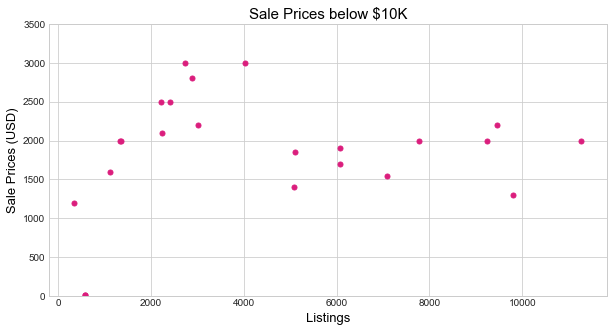

In [15]:
plt.figure(figsize = (10,5))

plt.plot(truliaLO.soldPrice, marker = 'o', linewidth = 0, markersize=5, color = '#db1e7d')
plt.ylim(0,3500)

plt.title('Sale Prices below $10K', fontsize = 15, color = 'black')
plt.ylabel('Sale Prices (USD)', fontsize = 13, color = 'black')
plt.xlabel('Listings', fontsize = 13, color = 'black')

plt.show()

 Additionally, for these same listings, the range of price/ sqft of the property is roughly below \$3/sqft. which is very far from the dataset mean of $573.92/ sqft (for all of NYC).

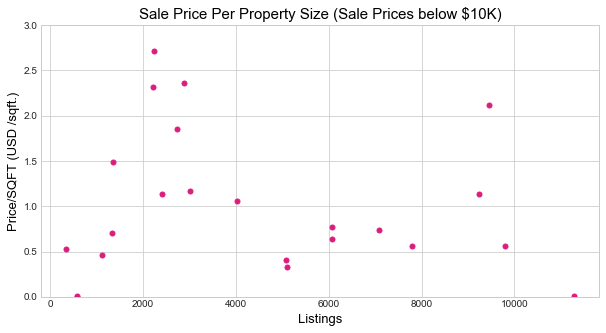

In [16]:
plt.figure(figsize = (10,5))

plt.plot(truliaLO.PricePerSQFT, marker = 'o', linewidth = 0, markersize=5, color = '#db1e7d')
plt.ylim(0,3)

plt.title('Sale Price Per Property Size (Sale Prices below $10K)', fontsize = 15, color = 'black')
plt.ylabel('Price/SQFT (USD /sqft.)', fontsize = 13, color = 'black')
plt.xlabel('Listings', fontsize = 13, color = 'black')

plt.show()

As such, my recommendation is to have these listings removed as potential data entry errors. A closer inspection on the trulia.com site shows these entry errors might be random (no clear trend with other variables and neighborhood prices).

In [17]:
mask1 = np.array([False if trulia2.address[i] in list(truliaLO.address) else True for i in range(len(trulia2.address))])

In [18]:
trulia3 = trulia2.loc[mask1].reset_index(drop=True)

**SQFT Outliers**

Checking lower and upper values of 1.5 times the Inner Quartile Rage to check for outlier range:

In [19]:
SF25 = np.percentile(trulia3.sqft, 25)
SF75 = np.percentile(trulia3.sqft, 75)
iqr15= 1.5* (SF75 - SF25)
low  = SF25 - iqr15
high = SF75 + iqr15
print('1.5 times Inner Quartile Range: ', '[',low,',',high,']')

1.5 times Inner Quartile Range:  [ -395.0 , 3693.0 ]


As with Sale Price, again for the purposes of identifying mistakes, the outlier range for sqft of listings does not seem realistic since there are definitely properties on the market that are above \~3,600 sqft.

The negative lower range value indicates that there are no outliers in the lower end

*GRAPHICAL/ VISUAL ANALYSIS*

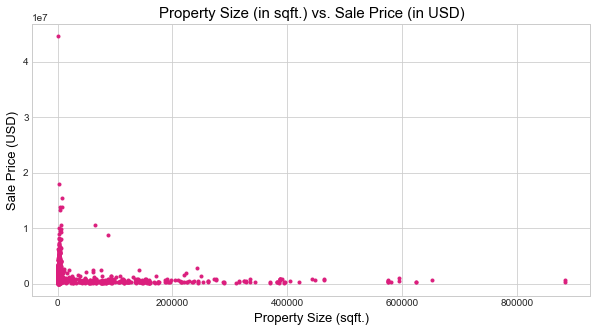

In [20]:
plt.figure(figsize = (10,5))

plt.scatter(trulia3.sqft, trulia3.soldPrice, marker = '.', color = '#db1e7d')

plt.title('Property Size (in sqft.) vs. Sale Price (in USD)', fontsize = 15, color = 'black')
plt.xlabel('Property Size (sqft.)', fontsize = 13, color = 'black')
plt.ylabel('Sale Price (USD)', fontsize = 13, color = 'black')

plt.show()

On the lower end of property sizes, there seems to be a clear outlier with a Sale Price north of \$40M, that will be investigated individually later. 

Right now for the purposes of an organized approach, we will focus on the larger end of the property size spectrum.

*LARGEST LISTINGS BY SQFT*

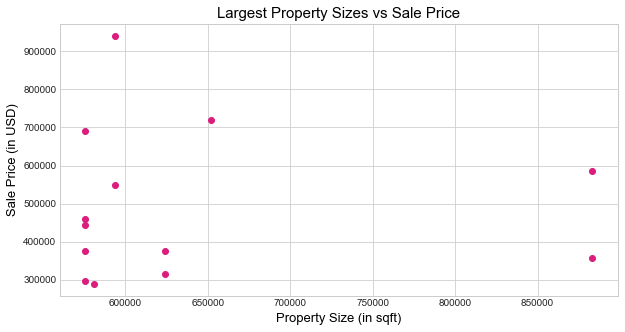

In [21]:
plt.figure(figsize = (10,5))

large = trulia3.loc[trulia3.sqft > 500000]
plt.scatter(large.sqft, large.soldPrice, color = '#db1e7d')

plt.title('Largest Property Sizes vs Sale Price', fontsize = 15, color = 'black')
plt.xlabel('Property Size (in sqft)', fontsize = 13, color = 'black')
plt.ylabel('Sale Price (in USD)', fontsize = 13, color = 'black')

plt.show()

In [22]:
trulia3.loc[trulia3.sqft > 500000]

,address,city,soldDate,soldPrice,sqft,zipCode,borough,PricePerSQFT
3005,7025 Yellowstone Blvd #9Y,Forest Hills,5-Jul-18,445000.0,575600,11375,Queens,0.773106
3228,7025 Yellowstone Blvd #9J,Forest Hills,23-Jul-18,690000.0,575600,11375,Queens,1.198749
3743,7025 Yellowstone Blvd #15K,Forest Hills,29-Aug-18,297500.0,575600,11375,Queens,0.516852
4797,7025 Yellowstone Blvd #15O,Forest Hills,14-Nov-18,375000.0,575600,11375,Queens,0.651494
5168,7025 Yellowstone Blvd #6X,Forest Hills,4-Dec-18,459000.0,575600,11375,Queens,0.797429
5678,6115 98th St #10C,Rego Park,8-Jan-19,290000.0,580800,11374,Queens,0.499311
7712,270 Jay St #15J,Brooklyn,12-Jun-18,357000.0,883265,11201,Brooklyn,0.404182
8111,460 Neptune Ave #12M,Brooklyn,22-Jul-18,315000.0,623800,11224,Brooklyn,0.504970
8220,201 Clinton Ave #15A,Brooklyn,6-Aug-18,720015.0,651914,11205,Brooklyn,1.104463
8253,2944 W 5th St #15E,Brooklyn,7-Aug-18,375000.0,623806,11224,Brooklyn,0.601148


The price range for the properties above 500,000 sqft. are in the upper ranges of Sale Price as well. 

The largest listings seems to be grouped by their zip codes, meaning they might be similar properties in a similar neighborhood.

While each individual listing cannot be discacrded, the two largest properties above 850,000 should certainly be closely investigated.

In [23]:
trulia3.loc[trulia3.sqft > 850000]

,address,city,soldDate,soldPrice,sqft,zipCode,borough,PricePerSQFT
7712,270 Jay St #15J,Brooklyn,12-Jun-18,357000.0,883265,11201,Brooklyn,0.404182
9765,175 Adams St #14F,Brooklyn,4-Dec-18,585000.0,883265,11201,Brooklyn,0.662315


Both properties are from the same zip code, 11201 in Brooklyn. 

In [24]:
code11201 = trulia3.loc[trulia3.zipCode == '11201']

 - There are 121 sold listings from 11201 on the Trulia site. 
 - The median property size was 1,160 sqft. 
 - The 95th percentile of property size was 171,000 sqft. 
 
 The specific properties being examined are far above that range. As such, they were investigated on the Trulia site.
 
 One listing was a studio apartment and the other was a 1 bedroom co-op. The sizes listed for those properties are not reasonable at all. There is a change that the property sizes that are shown belong to the entire apartment complex and not just the unit being sold. As such, those listings can be removed for our purposes.

In [25]:
trulia4 = trulia3.loc[trulia3.sqft < 850000].reset_index(drop=True)

**PricePerSQFT OUTLIERS**

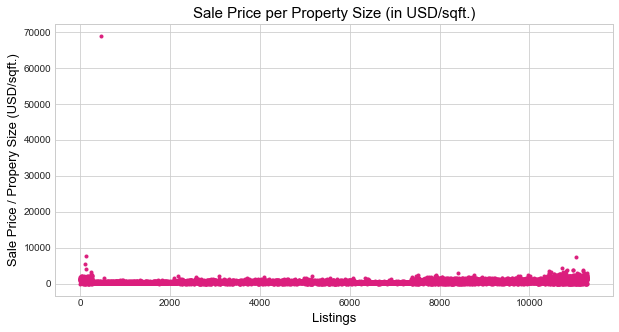

In [26]:
plt.figure(figsize = (10,5))

plt.plot(trulia4.PricePerSQFT, color = '#db1e7d', marker='.', linewidth=0)

plt.title('Sale Price per Property Size (in USD/sqft.)', fontsize = 15, color = 'black')
plt.xlabel('Listings', fontsize = 13, color = 'black')
plt.ylabel('Sale Price / Propery Size (USD/sqft.)', fontsize = 13, color = 'black')

plt.show()

Visualizing the price/sqft feature above, clearly shows an unusual listing. 

Checking the specific listing, following up with it on the Trulia site and comparing the other listings in the same neighborhood, this was clearly a data entry error and as such, the listing must be removed (as shown below):

In [27]:
trulia4.loc[trulia4.PricePerSQFT == np.max(trulia4.PricePerSQFT)]

,address,city,soldDate,soldPrice,sqft,zipCode,borough,PricePerSQFT
456,26 Hillwood Ct,Staten Island,15-Jun-18,44580000.0,648,10305,Staten Island,68796.296296


In [28]:
trulia5 = trulia4.loc[trulia4.PricePerSQFT != np.max(trulia4.PricePerSQFT)]

Coincidentally, this was also the largest Sale Price listed at \$44M (by a very large margin: the next highest listing is \$18M) and lends to the notion that this property really is an error

**SUMMARY:**

In [29]:
round(trulia5.describe(), 2)

,soldPrice,sqft,PricePerSQFT
count,11289.00,11289.00,11289.00
mean,878191.73,5881.31,569.15
std,753059.93,33147.63,417.60
min,20000.00,224.00,0.43
25%,520000.00,1138.00,326.39
50%,705000.00,1520.00,451.61
75%,970000.00,2160.00,662.13
max,18000000.00,651914.00,7604.56


Printing a final csv of the cleaned data set:

In [30]:
trulia5.to_csv('./data/trulia5_complete.csv')

- - -

<div class="alert alert-block alert-success">
</div>

# Analysis of Final Sale Price

In [31]:
# plt.figure(figsize=(10,8))
# scp.probplot(trulia5.soldPrice, plot=plt)
# plt.show()

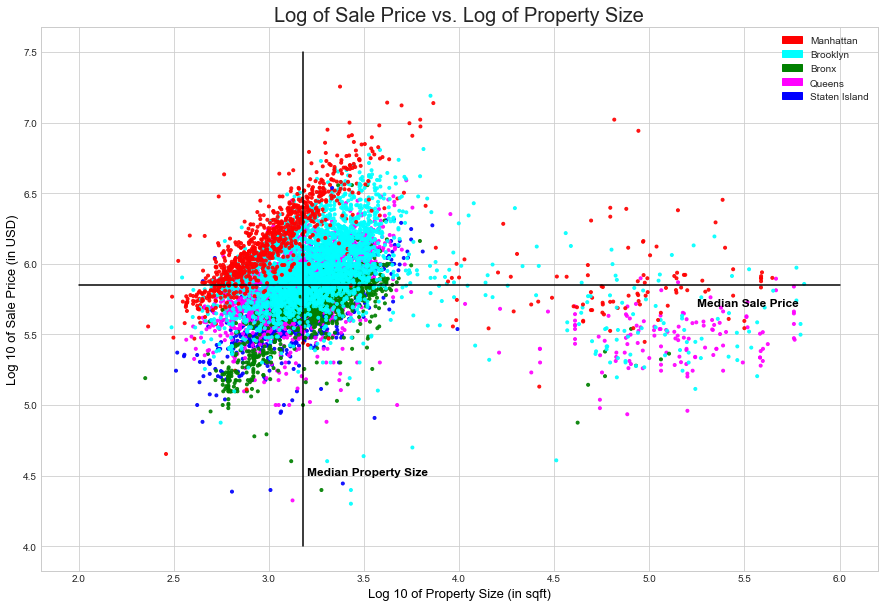

In [32]:
plt.figure(figsize = (15,10))

boro_colors = {'Manhattan'     : 'red', 
               'Brooklyn'      : 'cyan', 
               'Bronx'         : 'green', 
               'Queens'        : 'magenta', 
               'Staten Island' : 'blue'}

plt.scatter(np.log10(trulia5.sqft), np.log10(trulia5.soldPrice),
            color = trulia5.borough.apply(lambda x: boro_colors[x]), marker = '.', alpha=0.9)

sale = np.log10(np.median(trulia5.soldPrice))
plt.plot([2.0,6.0], [sale, sale], color='black')
plt.annotate('Median Sale Price', (5.25, sale-0.15), fontweight='bold', fontsize=12, color = 'black')

size = np.log10(np.median(trulia5.sqft))
plt.plot([size, size], [4.0,7.5], color='black')
plt.annotate('Median Property Size', (size+0.02, 4.5), fontweight='bold', fontsize=12, color = 'black')

plt.title('Log of Sale Price vs. Log of Property Size', fontsize=20)
plt.xlabel('Log 10 of Property Size (in sqft)', fontsize=13, color = 'black')
plt.ylabel('Log 10 of Sale Price (in USD)', fontsize=13, color = 'black')

patch = [pat.Patch(color=list(boro_colors.values())[i], label=list(boro_colors.keys())[i]) for i in range(5)]
plt.legend(handles=patch, loc='upper right')

plt.show()

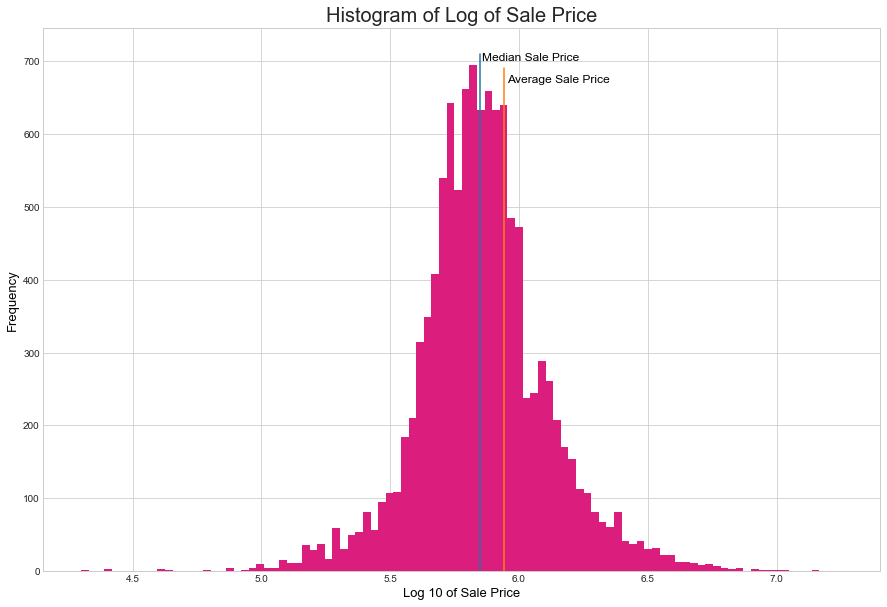

In [33]:
plt.figure(figsize=(15,10))

plt.hist(np.log10(trulia5.soldPrice), bins = 100, color='#db1e7d')

med = np.log10(np.median(trulia5.soldPrice))
plt.plot([med, med], [0,710])
plt.annotate('Median Sale Price', (med+0.01, 700), fontsize=12, color = 'black')

avg = np.log10(np.mean(trulia5.soldPrice))
plt.plot([avg, avg], [0,690])
plt.annotate('Average Sale Price', (avg+0.01, 670), fontsize=12, color = 'black')

plt.title('Histogram of Log of Sale Price', fontsize=20)
plt.xlabel('Log 10 of Sale Price', fontsize = 13, color = 'black')
plt.ylabel('Frequency', fontsize = 13, color = 'black')
plt.show()

Correlation between Sold Price and SQFT

In [34]:
corr = trulia5.corr()
corr[['soldPrice']][1:2]

,soldPrice
sqft,-0.050075


- - -

# Analysis by Property Size

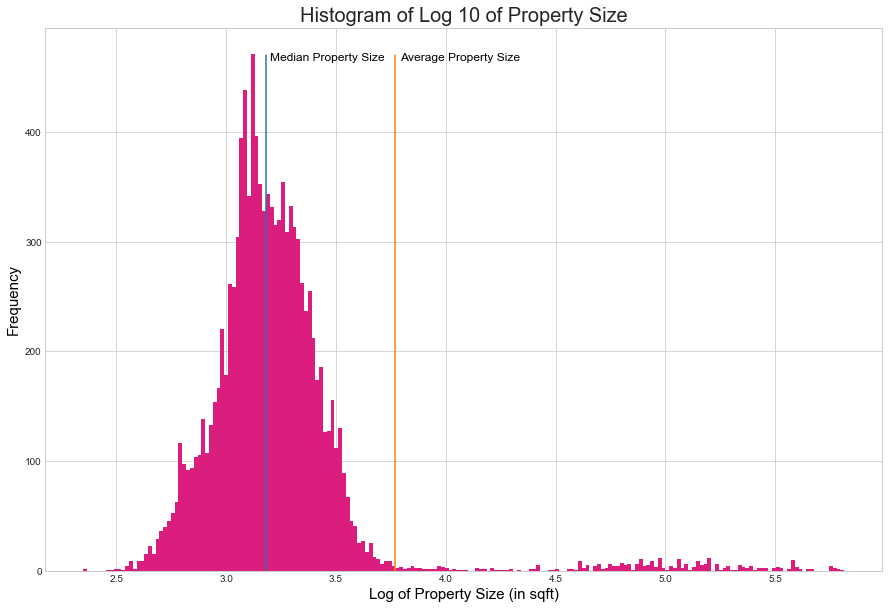

In [35]:
plt.figure(figsize=(15,10))

plt.hist(np.log10(trulia5.sqft), bins = 200, color="#db1e7d")

med = np.log10(np.median(trulia5.sqft))
plt.plot([med, med], [0,470])
plt.annotate('Median Property Size', (med+0.02, 465), fontsize=12, color = 'black')

avg = np.log10(np.mean(trulia5.sqft))
plt.plot([avg, avg], [0,470])
plt.annotate('Average Property Size', (avg+0.02, 465), fontsize=12, color = 'black')

plt.title('Histogram of Log 10 of Property Size', fontsize=20)
plt.xlabel('Log of Property Size (in sqft)', fontsize=15, color='black')
plt.ylabel('Frequency', fontsize=15, color='black')

plt.show()

- - -

# Analysis by Borough

Summary statistics by Borough

In [36]:
trulia_borough = trulia5.groupby('borough')
summaryborough = round(trulia_borough.agg(['count', 'median', 'std']), 3)
summaryborough

soldPrice                          sqft                     \
                  count     median          std count  median        std   
borough                                                                    
Bronx              1272   525000.0   265619.701  1272  1803.5   6415.238   
Brooklyn           3041   875000.0   735478.469  3041  1732.0  36505.000   
Manhattan          1096  1211250.0  1616369.838  1096  1046.0  44723.615   
Queens             3926   730000.0   330191.091  3926  1480.0  39160.641   
Staten Island      1954   540000.0   227583.372  1954  1440.0    749.068   

              PricePerSQFT                     
                     count    median      std  
borough                                        
Bronx                 1272   276.231  113.597  
Brooklyn              3041   536.952  360.659  
Manhattan             1096  1345.531  677.921  
Queens                3926   485.355  212.868  
Staten Island         1954   351.528  131.149

In [37]:
a = summaryborough['soldPrice']['count'].sort_values()
b = summaryborough['soldPrice']['median'].sort_values()
c = summaryborough['sqft']['median'].sort_values()
d = summaryborough['PricePerSQFT']['median'].sort_values()

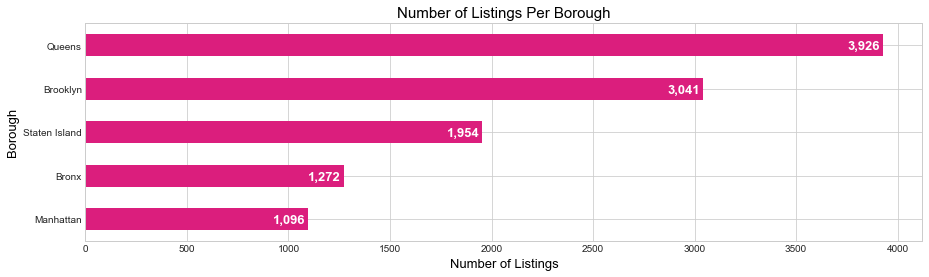

In [38]:
plt.figure(figsize=(15,4))

a.plot.barh(color='#db1e7d')

for i, v in enumerate(a):
    plt.text(v-175, i-0.1, com.comma(v), color='w', fontweight='bold', fontsize=13)

plt.title('Number of Listings Per Borough', fontsize=15, color='black')
plt.xlabel('Number of Listings', fontsize=13, color='black')
plt.ylabel('Borough', fontsize=13, color='black')
plt.show()

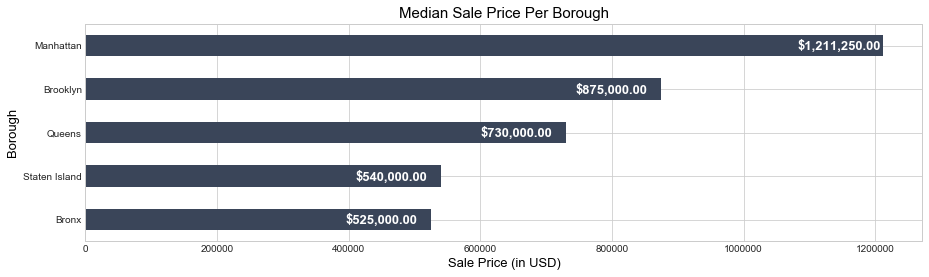

In [39]:
plt.figure(figsize=(15,4))

b.plot.barh(color='#3a4559')

for i, v in enumerate(b):
    plt.text(v-130000, i-0.1, '$'+com.comma(v)+'.00', color='w', fontweight='bold', fontsize=13)

plt.title('Median Sale Price Per Borough', fontsize=15, color='black')
plt.xlabel('Sale Price (in USD)', fontsize=13, color='black')
plt.ylabel('Borough', fontsize=13, color='black')
plt.show()

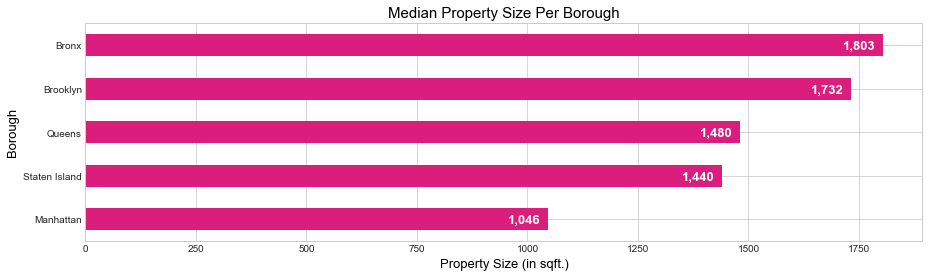

In [40]:
plt.figure(figsize=(15,4))

c.plot.barh(color='#db1e7d')

for i, v in enumerate(c):
    plt.text(v-90, i-0.1, com.comma(v), color='w', fontweight='bold', fontsize=13)

plt.title('Median Property Size Per Borough', fontsize=15, color='black')
plt.xlabel('Property Size (in sqft.)', fontsize=13, color='black')
plt.ylabel('Borough', fontsize=13, color='black')
plt.show()

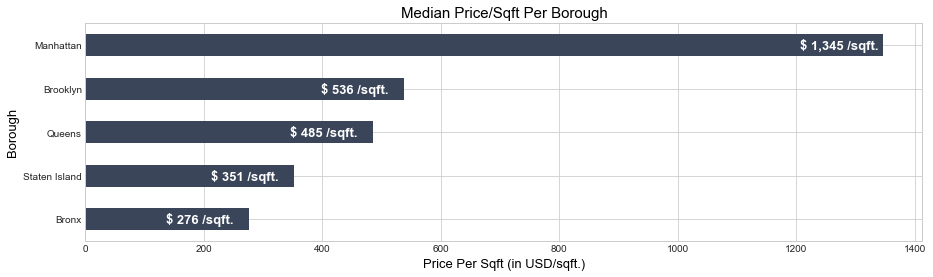

In [41]:
plt.figure(figsize=(15,4))

d.plot.barh(color='#3a4559') 

for i, v in enumerate(d):
    plt.text(v-140, i-0.1, '$ '+com.comma(v)+' /sqft.', color='w', fontweight='bold', fontsize=13)

plt.title('Median Price/Sqft Per Borough', fontsize=15, color='black')
plt.xlabel('Price Per Sqft (in USD/sqft.)', fontsize=13, color='black')
plt.ylabel('Borough', fontsize=13, color='black')
plt.show()

- - -

# Analysis by Zip Code

In [42]:
len(trulia5.zipCode.unique())

180

In [43]:
trulia_zipcode = trulia5.groupby(['zipCode', 'borough'])
summaryZipcode = round(trulia_zipcode.agg(['count', 'median', 'std']), 2)

e = summaryZipcode['soldPrice']['count'].sort_values(ascending=False).head(20)
e = e.iloc[::-1]

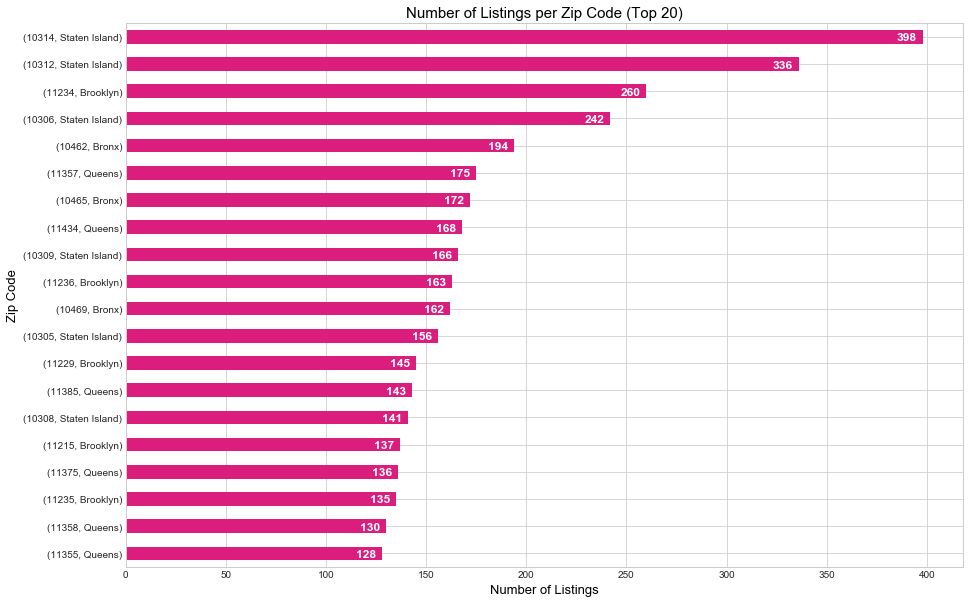

In [44]:
plt.figure(figsize=(15,10))

e.plot.barh(color='#db1e7d')

for i, v in enumerate(e):
    plt.text(v-13, i-0.13, com.comma(v), color='w', fontweight='bold', fontsize=12)
    
plt.title('Number of Listings per Zip Code (Top 20)', fontsize=15, color='black')
plt.xlabel('Number of Listings', fontsize=13, color='black')
plt.ylabel('Zip Code', fontsize=13, color='black')
plt.show()

- - -

# Sales Date information:

In [45]:
trulia5.soldDate = trulia5.soldDate.apply(lambda date: dt.strptime(date, '%d-%b-%y'))

C:\Users\sabbi\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [46]:
print('Earliest         :', dt.date(np.min(trulia5.soldDate)).strftime('%B %d, %Y'))
print('Latest           :', dt.date(np.max(trulia5.soldDate)).strftime('%B %d, %Y'))

Earliest         : May 11, 2018
Latest           : February 08, 2019


Since the Trulia site only shows the sales information for the previous 9 months from the day of scraping, as of this project, the sale date range is from May 11, 2018 until February 08, 2019. Due to the lack of sales by month throughout the year (namely February, March, April and May) I believe this dataset cannot be used for any meaningful data analysis or visualization. 

- - -

# Population per Borough (US Census Bureau, 2010)

In [47]:
boroPop = pd.DataFrame([['Bronx', 1384794],
                        ['Brooklyn', 2504706],
                        ['Manhattan', 1586184],
                        ['Queens', 2230545],
                        ['Staten Island', 468730]],
                        columns =['Borough', 'Population (2010)'])
boroPop = boroPop.set_index('Borough')
boroPop = boroPop.sort_values('Population (2010)', ascending=False)
boroPop['Population (2010)'] = boroPop['Population (2010)'].apply(lambda x: "{:,}".format(x))
boroPop

,Population (2010)
Borough,
Brooklyn,"2,504,706"
Queens,"2,230,545"
Manhattan,"1,586,184"
Bronx,"1,384,794"
Staten Island,"468,730"


- - -